# 가정 전기사용량 예측
- 한 가정의 4년간 데이터 (2016.12 ~ 2020.11) 분단위 측정
- UCI에서 제공
## 특성
- global active power: 전체 사용량(kilowatts).
- global reactive power: The total reactive power (사용되지 않은 전력)
- voltage: Average voltage (volts).
- global intensity: Average current intensity (amps).
- sub metering 1: 부억 사용량 (watt-hours of active energy).
- sub metering 2: 세탁실 사용량 (watt-hours of active energy).
- sub metering 3: 온도 조절 사용량 (watt-hours of active energy).

In [0]:
!curl -L https://bit.ly/2PnYqsZ -o household_power_consumption.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   160  100   160    0     0    154      0  0:00:01  0:00:01 --:--:--   154
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
100  1034    0  1034    0     0    173      0 --:--:--  0:00:05 --:--:--   967
100 19.6M  100 19.6M    0     0  1286k      0  0:00:15  0:00:15 --:--:-- 3750k


In [0]:
!ls household_power_consumption.txt

household_power_consumption.txt


In [0]:
import os.path
import zipfile

if not os.path.exists('household_power_consumption.txt'):
    zip = zipfile.ZipFile('household_power_consumption.zip')
    zip.extractall()

In [0]:
# 다른 방법
# !unzip household_power_consumption.zip

Archive:  household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
!head -5 household_power_consumption.txt

- 결측치 확인이 필요하다
- 구분자가 ';' 이다.
- RAM이 충분하므로 수치가 아니라 문자열로 데이터를 읽는 것에 경고하지 않도록 한다 '?'
- datetime 형식 데이터를 자동감지한다 (이를 인덱스로 사용하겠다)

In [0]:
from numpy import nan
from pandas import read_csv
dataset = read_csv('household_power_consumption.txt', 
 sep=';', header=0, low_memory=False)
print(dataset.shape)

(2075259, 9)


In [0]:
dataset[:3]

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


In [0]:
dataset.Date.dtype

dtype('O')

In [0]:
dataset = read_csv('household_power_consumption.txt', 
 sep=';', header=0, low_memory=False, infer_datetime_format=True,
 parse_dates={'datetime':[0,1]}, index_col=['datetime'])
dataset[:3]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


In [0]:
# 결측치 ?를 교체
dataset.replace('?', nan, inplace=True)
# 세가지 이외의 전력사용량 계산 (나머지 값))
values = dataset.values.astype('float32')
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - 
     (values[:,4] + values[:,5] + values[:,6])
# csv 파일로 저장 후 다시 읽는다
dataset.to_csv('household_power_consumption.csv')
dataset = read_csv('household_power_consumption.csv', header=0, 
    infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


# EDA - 패턴보기
## 전체 데이터의 plot 보기

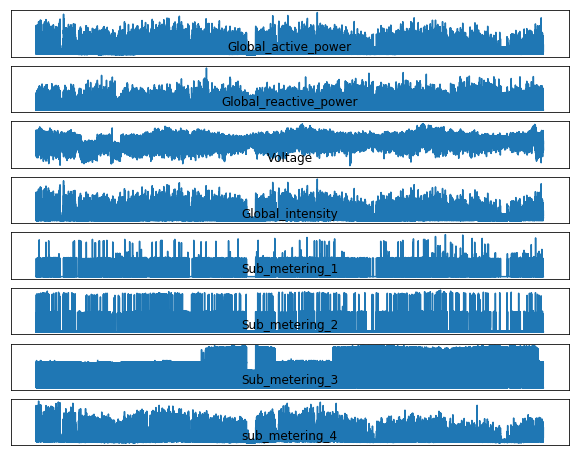

In [0]:
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline

pyplot.figure(figsize=(10,8))
for i in range(len(dataset.columns)):
    pyplot.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    pyplot.plot(dataset[name])
    pyplot.title(name, y=0)
    pyplot.yticks([])
    pyplot.xticks([])
pyplot.show()

## 연도별 전력 사용량
- 2016년은 제외
- 여름에 사용량이 줄어드는 것을 알 수 있다.
- 전력 사용량이 매우 적은 달이 반복된다.

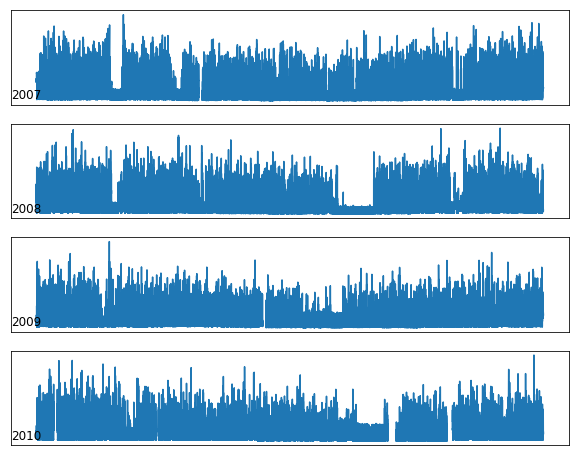

In [0]:
from pandas import read_csv
from matplotlib import pyplot
years = ['2007', '2008', '2009', '2010']
pyplot.figure(figsize=(10,8))
for i in range(len(years)):
    ax = pyplot.subplot(len(years), 1, i+1)
    year = years[i]
    result = dataset[str(year)]
    pyplot.plot(result['Global_active_power'])
    pyplot.title(str(year), y=0, loc='left')
    pyplot.yticks([])
    pyplot.xticks([])
pyplot.show()

## 2017년 데이터를 월별로 보겠다.
- 월별로 주기적 패턴이 반복되고, 가끔 휴가 기간이 있다

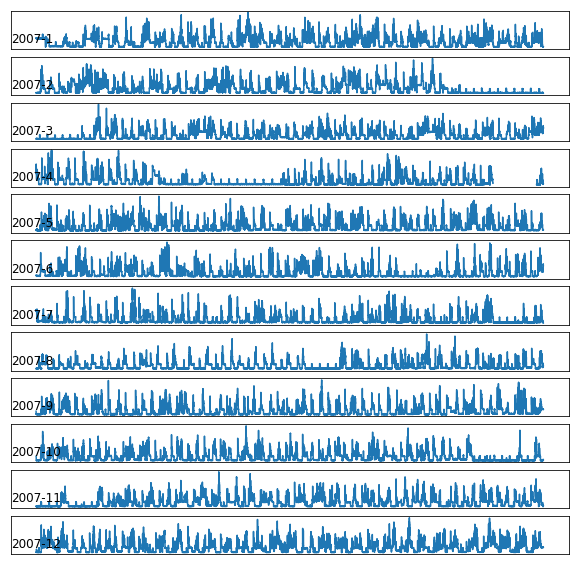

In [0]:
from pandas import read_csv
from matplotlib import pyplot
months = [x for x in range(1, 13)]
pyplot.figure(figsize=(10,10))
for i in range(len(months)):
    ax = pyplot.subplot(len(months), 1, i+1)
    month = '2007-' + str(months[i])
    result = dataset[month]
    pyplot.plot(result['Global_active_power'])
    pyplot.title(month, y=0, loc='left')
    pyplot.yticks([])
    pyplot.xticks([])
pyplot.show()

## 일일 변화를 보겠다
- 아침에 사용량이 시작되며, 겨울이므로 새벽에 전기가 사용되고 있다 (난방)

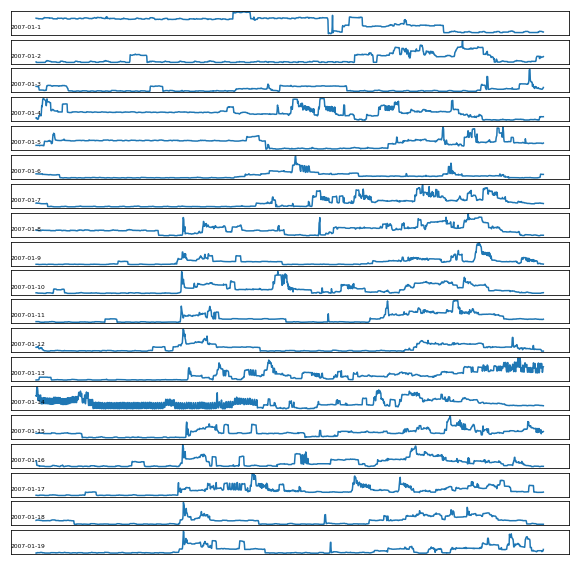

In [0]:
from pandas import read_csv
from matplotlib import pyplot
days = [x for x in range(1, 20)]
pyplot.figure(figsize=(10,10))
for i in range(len(days)):
    ax = pyplot.subplot(len(days), 1, i+1)
    day = '2007-01-' + str(days[i])
    result = dataset[day]
    pyplot.plot(result['Global_active_power'])
    pyplot.title(day, y=0, loc='left', size=6)
    pyplot.yticks([])
    pyplot.xticks([])
pyplot.show()

# 데이터의 분포를 히스토그램으로 보겠다
- 전압 분포만 가우시안으로 보인다
- 다른 값은 모두 skewed
- 전력 사용량은 두개의 봉우리를 갖는다

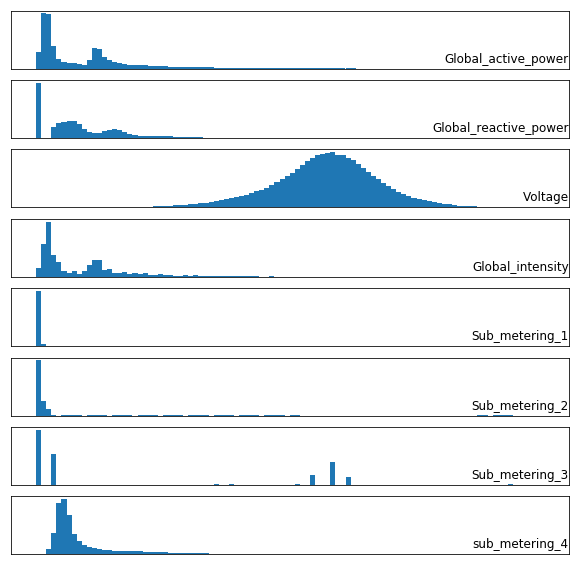

In [0]:
from pandas import read_csv
from matplotlib import pyplot
pyplot.figure(figsize=(10,10))
for i in range(len(dataset.columns)):
    pyplot.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    dataset[name].hist(bins=100)
    pyplot.title(name, y=0, loc='right')
    pyplot.yticks([])
    pyplot.xticks([])
pyplot.show()

## 4년간 전력사용량 데이터를 보겠다.
- 0.3kW, 1.3kW 근처에 피크가 있다.

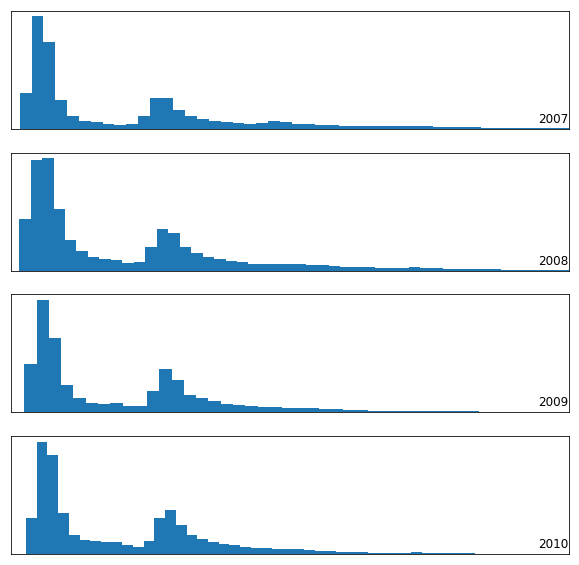

In [0]:
from pandas import read_csv
from matplotlib import pyplot
years = ['2007', '2008', '2009', '2010']
pyplot.figure(figsize=(10,10))
for i in range(len(years)):
	ax = pyplot.subplot(len(years), 1, i+1)
	year = years[i]
	result = dataset[str(year)]
	result['Global_active_power'].hist(bins=100)
	# zoom in on the distribution
	ax.set_xlim(0, 5)
	pyplot.title(str(year), y=0, loc='right')
	pyplot.yticks([])
	pyplot.xticks([])
pyplot.show()

## 월별 히스토그램
- 여름에 전력 소비가 적고, 겨울에 많은 것을 알 수 있다.

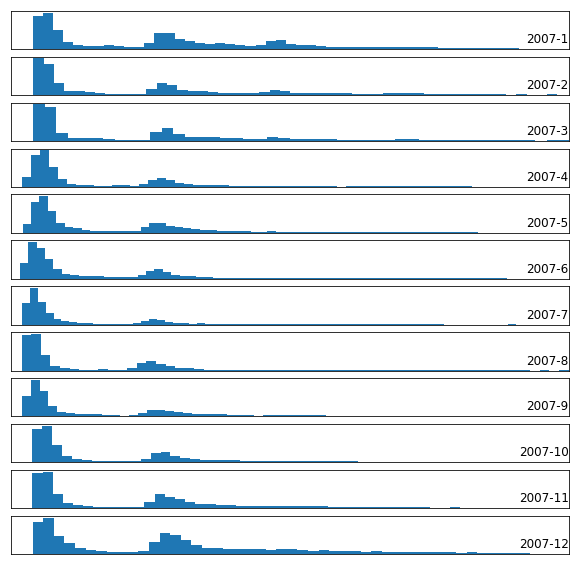

In [0]:
from pandas import read_csv
from matplotlib import pyplot
months = [x for x in range(1, 13)]
pyplot.figure(figsize=(10,10))
for i in range(len(months)):
	ax = pyplot.subplot(len(months), 1, i+1)
	month = '2007-' + str(months[i])
	result = dataset[month]
	result['Global_active_power'].hist(bins=100)
	ax.set_xlim(0, 5)
	pyplot.title(month, y=0, loc='right')
	pyplot.yticks([])
	pyplot.xticks([])
pyplot.show()

# 문제정의
- 미래의 전력 사용량 예측
- 예를 들어, 내일의 시간별 예측, 다음주의 일별 예측, 다음달의 일별 예측, 내년의 월별 예측
- 다중변수 다중스텝 문제 예

## 전처리
- differece를 사용함으로써 주기적인 사이클을 조절할 수 있다.
- 정규화 (스케일링)으로 단위가 다른 것을 조절할 수 있다.
- 도메인 지식의 반영: 주중, 주일의 반영, 낮시간 (외출시간)의 반영, 공휴일, 계절 등
## 모델링
- Naive 모델
- 선형모델 (ARIMA)
- 머신러닝 (지도학습 모델 사용 X, y)
- 딥러닝 (CNN, RNN, CNN-LSTM)



# 나이브 모델 (내일의 예측)
- persistent
- 작년의 같은 날과 같다
- 지난 며칠간의 평균치


## 결측치 처리 : 24시간 전의 값으로 대체

In [0]:
dataset.shape

(2075259, 8)

In [0]:
dataset.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
sub_metering_4           25979
dtype: int64

In [0]:
from numpy import nan
from numpy import isnan
def fill_missing(values):
  one_day = 60 * 24
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
     if isnan(values[row, col]):
       values[row, col] = values[row - one_day, col]
    
fill_missing(dataset.values)

In [0]:
dataset.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

## 일일 단위로 리샘플링

In [0]:
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
print(daily_data.shape)
# save 
daily_data.to_csv('household_power_consumption_days.csv')
daily_data.head()

(1442, 8)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


## 1주일 후 예측
- 7개의 일일 데이터를 예측하는 방법 사용
- RMSE를 1주일 전체로 구하고, 각 일자별로 측정한다.
- 훈련 데이터로 앞의 3년간 데이터 사용
- 일요일~토요일 구간을 기본 단위로 사용 (훈련 데이터와 테스트 데이터 각각에 대해서)